# Leitura da ImageNet Mobile a partir de uma rede neural em formato Caffe

Este notebook tem instruções sobre como carregar uma rede neural pré-treinada armazenada em um arquivo.

Esta rede neural é um classificador obtido por *machine learning* com dados da *ImageNet*. Isso significa que o data set disponível em [http://www.image-net.org/](http://www.image-net.org/) foi usado para treinar esta rede neural até que aprendesse a fazer esta categorização.

Em *machine learning* o computador aprende a partir de amostrar classificadas por seres humanos. Tais classificações estão disponíveis no site mencionado acima.

Pode-se de forma muito superficial dizer que as redes neurais realizam multiplicações de matrizes que resultam em convoluções. De forma semelhante ao que foi visto nos filtros lineares que implementam *blur* ou *deteção de borda*. Após as convoluções frequentamente as saídas das redes passam por funções de ativação que são semelhantes à regressão logísitca vista em Ciência dos Dados.

Para visualizar melhor uma rede neural em ação, recomendamos este demo [An Interactive Node-Link Visualization of Convolutional Neural Networks](https://adamharley.com/nn_vis/)   que mostra em detalhes uma rede simples usada para reconhecer dígitos.



In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

%matplotlib inline

## Verificação do setup de OpenCV e Diretório

In [2]:
cv2.__version__

'4.6.0'

In [3]:
os.getcwd()

'c:\\Users\\anton\\Projects\\robotica\\robot22.2\\aula03'

In [4]:
proto = "./mobilenet_detection/MobileNetSSD_deploy.prototxt.txt" # descreve a arquitetura da rede
model = "./mobilenet_detection/MobileNetSSD_deploy.caffemodel" # contém os pesos da rede em si

## Instanciação da rede neural:

In [5]:
net = cv2.dnn.readNetFromCaffe(proto, model)

## Categorias da  MobileNet

*Nota importante*: estas categorias são definidas no momento de treinamento e não se pode alterar esta lista. Ela apenas descreve as categorias que a rede já sabe.

Para *alterar* estas categorias é preciso retreinar a rede.



In [6]:
CLASSES = ["background", "aeroplane", "bicycle", "bird", "boat",
	"bottle", "bus", "car", "cat", "chair", "cow", "diningtable",
	"dog", "horse", "motorbike", "person", "pottedplant", "sheep",
	"sofa", "train", "tvmonitor"]

## Leitura da imagem que vai ser classificada

In [7]:
img = cv2.imread("cat_bike.png")
CONFIDENCE = 0.7
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

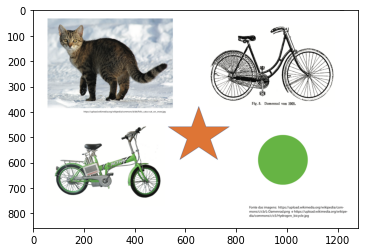

In [8]:
in_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(in_rgb)

### Engine de deteção

Sugerimos que inclua esta função *detect* em seu código exatamente com está. Se precisar filtrar (por exemplo analisar somente uma categoria de interessa) o faça na tupla de resultados.


In [9]:
def detect(frame):
    """
        Recebe - uma imagem colorida BGR
        Devolve: objeto encontrado
    """
    image = frame.copy()
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 0.007843, (300, 300), 127.5)

    # pass the blob through the network and obtain the detections and
    # predictions
    print("[INFO] computing object detections...")
    net.setInput(blob)
    detections = net.forward()

    results = []

    # loop over the detections
    for i in np.arange(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with the
        # prediction
        confidence = detections[0, 0, i, 2]

        # filter out weak detections by ensuring the `confidence` is
        # greater than the minimum confidence


        if confidence > CONFIDENCE:
            # extract the index of the class label from the `detections`,
            # then compute the (x, y)-coordinates of the bounding box for
            # the object
            idx = int(detections[0, 0, i, 1])
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # display the prediction
            label = "{}: {:.2f}%".format(CLASSES[idx], confidence * 100)
            print("[INFO] {}".format(label))
            cv2.rectangle(image, (startX, startY), (endX, endY),
                COLORS[idx], 2)
            y = startY - 15 if startY - 15 > 15 else startY + 15
            cv2.putText(image, label, (startX, y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS[idx], 2)

            results.append((CLASSES[idx], confidence*100, (startX, startY),(endX, endY) ))

    # show the output image
    return image, results

Vamos executar a deteção

In [10]:
saida, resultados = detect(img)

[INFO] computing object detections...
[INFO] bicycle: 99.99%
[INFO] bicycle: 99.96%
[INFO] cat: 99.83%


E iterar sobre os resultados. Os resultados contém a categoria, os pontos do retângulo que identificam o objeto encontrado e  nível de certeza da classificação.

## Tupla de resultados

Os resultados são devolvidos como uma lista de tuplas com o formato:
```python 

    ("categoria", confiança, (x1, y1), (x2, y2))

```

In [11]:
resultados

[('bicycle', 99.9937891960144, (698, 62), (1185, 361)),
 ('bicycle', 99.9582827091217, (76, 471), (508, 735)),
 ('cat', 99.82733726501465, (78, 47), (537, 363))]

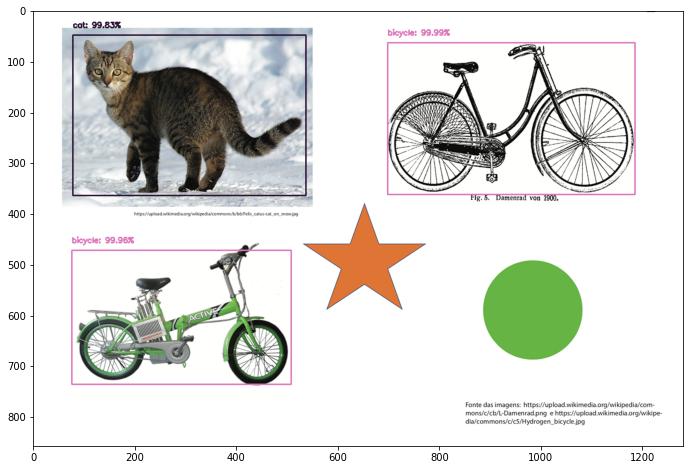

In [12]:
saida_rgb = cv2.cvtColor(saida, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12,8))
plt.imshow(saida_rgb)

## Trabalhando com índices dos resultados

Precisamos sempre lembrar que a *OpenCV* preferencialmente trabalha com índices na ordem `x, y` mas o *numpy* trabalha com índices na ordem `linha, coluna` 


In [13]:
s = saida_rgb

In [14]:
resultados[2]

('cat', 99.82733726501465, (78, 47), (537, 363))

Vamos guardar na variável `inicio`  o início do retângulo que define o gato. Lembrando que é formato `x,y`

In [15]:
inicio = resultados[2][2]

In [16]:
inicio

(78, 47)

Agora na variável `fim` o final do retângulo

In [17]:
fim = resultados[2][3]

In [18]:
fim

(537, 363)

Para montar o *slice* precisamos lembrar que agora deve ser `y,x` porque a imagem é uma matriz *numpy* que segue a ordem `linha, coluna`

In [19]:
img_saida2 = s[inicio[1]:fim[1], inicio[0]:fim[0]]

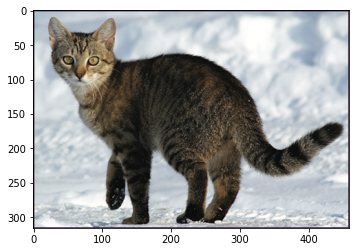

In [20]:
plt.imshow(img_saida2)